## <b> Sentiment Analysis </b>

In this project, prediction of the sentiment of a text is performed. The prediction is determines if a text has negative, positive or neutral connotations

In [51]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from matplotlib import rcParams
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [1]:
import re
import nltk
import string
import collections
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [3]:
import sys
sys.path.insert(0, '')
import nlp_utils as nu
import contractions

### Loading in the data

In [4]:
with open('TextAnalytics.txt', 'r') as f:
    text = f.read()

In [5]:
print(len(text))
text[:5000]

1320097


'0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you\'ll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to th

### Text Normalization

This is the process of transforming a text into standard form. E.g the words `"goooood"` and `"gud"` are transformed to `"good"`, etc..

First, we split the text into samples

In [6]:
# Splitting the text at \n
text = text.split('\n')

print(len(text))
text[:3]

1000


['0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you\'ll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to t

In [7]:
# Splitting at (\t)
corpus = [text]
for sent in text:
    corpus.append(sent.split('\t'))

In [8]:
len(corpus)

1001

In [9]:
corpus[9]

['8,"Encouraged by the positive comments about this film on here I was looking forward to watching this film. Bad mistake. I\'ve seen 950+ films and this is truly one of the worst of them - it\'s awful in almost every way: editing, pacing, storyline, \'acting,\' soundtrack (the film\'s only song - a lame country tune - is played no less than four times). The film looks cheap and nasty and is boring in the extreme. Rarely have I been so happy to see the end credits of a film. <br /><br />The only thing that prevents me giving this a 1-score is Harvey Keitel - while this is far from his best performance he at least seems to be making a bit of an effort. One for Keitel obsessives only."']

In [10]:
only_letters = re.sub(r'[^a-zA-Z]', " ", str(corpus))

### Tokenization

In [11]:
# Lowercase
only_letters = only_letters.lower()

token = nltk.sent_tokenize(only_letters)
token[0][:500]

'      one of the other reviewers has mentioned that after watching just   oz episode you  ll be hooked  they are right  as this is exactly what happened with me  br    br   the first thing that struck me about oz was its brutality and unflinching scenes of violence  which set in right from the word go  trust me  this is not a show for the faint hearted or timid  this show pulls no punches with regards to drugs  sex or violence  its is hardcore  in the classic use of the word  br    br   it is ca'

### AlphaNumeric Characters

In [15]:
def num_dec_al(word):
    if word.isnumeric():
        return 'xxxxxx'
    elif word.isdecimal():
        return 'xxx...'
    elif word.isalpha():
        return word
    else:
        return 'xxxaaa'

def clean_nda(token):
    tokens = nu.w_tokenization(token)
    map_list = list(map(num_dec_al, tokens))
    return " ".join(map_list)

corpus_nda = list(map(clean_nda, token))

corpus_nda[0][:500]

'one of the other reviewers has mentioned that after watching just oz episode you ll be hooked they are right as this is exactly what happened with me br br the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word br br it is called oz as that is the nicknam'

Expanding Contractions

In [16]:
conm = contractions.CONTRACTION_MAP
def contraction_remove(corpus_nda):
    for key, value in conm.items():
        corpus_nda = re.sub(rf"{key}", f'{value}', corpus_nda)
    return corpus_nda

special = string.punctuation
def w_tokenization(corpus_nda):
    # convert to lower case
    corpus_nda = corpus_nda.lower()
    # contraction
    corpus_nda = contraction_remove(corpus_nda)
    tokens = nltk.word_tokenize(corpus_nda) # Word tokens

corpus_nda[0][:500]

'one of the other reviewers has mentioned that after watching just oz episode you ll be hooked they are right as this is exactly what happened with me br br the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word br br it is called oz as that is the nicknam'

In [18]:
data = [corpus_nda]
for sent in text:
    data.append(sent.split('\t'))

data.append(sent.split('\n'))

data[1:10]

[['0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you\'ll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to 

In [30]:
df = pd.DataFrame(data)
df.drop([1,2,3,4,5,6], axis=1, inplace=True)
df.rename(columns = {0: 'Text'}, inplace=True)
df

,Text
0,one of the other reviewers has mentioned that ...
1,"0,""One of the other reviewers has mentioned th..."
2,"1,""A wonderful little production. <br /><br />..."
3,"2,""I thought this was a wonderful way to spend..."
4,"3,""Basically there's a family where a little b..."
...,...
997,"996,""I hated it. I hate self-aware pretentious..."
998,"997,""I usually try to be professional and cons..."
999,"998,""If you like me is going to see this in a ..."
1000,"999,""This is like a zoology textbook, given th..."


We have to remove the first and last samples from the DataFrame, because they are repeated

In [31]:
df.drop([0,1001], inplace=True)

In [32]:
df

,Text
1,"0,""One of the other reviewers has mentioned th..."
2,"1,""A wonderful little production. <br /><br />..."
3,"2,""I thought this was a wonderful way to spend..."
4,"3,""Basically there's a family where a little b..."
5,"4,""Petter Mattei's """"Love in the Time of Money..."
...,...
996,"995,""Nothing is sacred. Just ask Ernie Fosseli..."
997,"996,""I hated it. I hate self-aware pretentious..."
998,"997,""I usually try to be professional and cons..."
999,"998,""If you like me is going to see this in a ..."


### Removing additional characters present in the Dataframe

In [36]:
df.replace('\d+', '', regex = True, inplace=True)
df.replace(',', '', regex = True, inplace=True)
df.replace('br', '', regex = True, inplace=True)
df.replace('"', '', regex = True, inplace=True)
df.replace("'", '', regex = True, inplace=True)
df.replace('?', '', inplace=True)
df.replace("-", '', regex = True, inplace=True)
df.replace('*', '', inplace=True)
df.replace('***', '', inplace=True)
df.replace('< />', '', regex=True, inplace=True)

In [34]:
df['Text'] = df['Text'].str.strip('[')
df['Text'] = df['Text'].str.strip(']')
df['Text'] = df['Text'].str.strip('(')
df['Text'] = df['Text'].str.strip(')')

In [37]:
df

,Text
1,One of the other reviewers has mentioned that ...
2,A wonderful little production. The filming tec...
3,I thought this was a wonderful way to spend ti...
4,Basically theres a family where a little boy (...
5,Petter Matteis Love in the Time of Money is a ...
...,...
996,Nothing is sacred. Just ask Ernie Fosselius. T...
997,I hated it. I hate selfaware pretentious inani...
998,I usually try to be professional and construct...
999,If you like me is going to see this in a film ...


### Lemmatization of the text column

In [40]:
df['Text'] = df['Text'].apply(nu.lemmatization_sentence)

In [41]:
Text = df['Text']

In [43]:
# Represent the Series as a numpy array
token = Text.values

In [44]:
token = nltk.sent_tokenize(str(token))

In [45]:
data = np.array(token)

In [46]:
stop = stopwords.words('english')

### Removing stopwords from the dataframe

In [47]:
text = data
text_tokens = word_tokenize(str(text))

tokens_without_sw = [word for word in text_tokens if not word in stop]

In [49]:
tokens_without_sw

['[',
 '``',
 '[',
 "'one",
 'reviewer',
 'mention',
 'watch',
 'oz',
 'episode',
 'youll',
 'hook',
 'right',
 'exactly',
 'happen',
 'me.the',
 'first',
 'thing',
 'strike',
 'oz',
 'utality',
 'unflinching',
 'scene',
 'violence',
 'set',
 'right',
 'word',
 'go',
 'trust',
 'show',
 'faint',
 'hearted',
 'timid',
 'show',
 'pull',
 'punch',
 'regard',
 'drug',
 'sex',
 'violence',
 'hardcore',
 'classic',
 'use',
 'word.it',
 'call',
 'oz',
 'nickname',
 'give',
 'oswald',
 'maximum',
 'security',
 'state',
 'penitentary',
 'focus',
 'mainly',
 'emerald',
 'city',
 'experimental',
 'section',
 'prison',
 'cell',
 'glass',
 'front',
 'face',
 'inwards',
 'privacy',
 'high',
 'agenda',
 'em',
 'city',
 'home',
 'many',
 '..',
 'aryan',
 'muslim',
 'gangstas',
 'latinos',
 'christian',
 'italian',
 'irish',
 '....',
 'scuffles',
 'death',
 'stare',
 'dodgy',
 'dealing',
 'shady',
 'agreement',
 'never',
 'far',
 'away.i',
 'would',
 'say',
 'main',
 'appeal',
 'show',
 'due',
 'fact',

### Visualisation

(-0.5, 399.5, 199.5, -0.5)

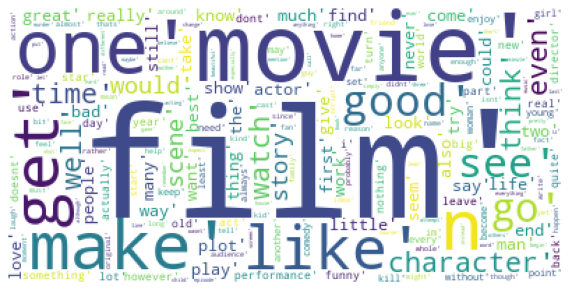

In [54]:
wordcloud = WordCloud(background_color = 'white', max_words = 1000).generate(str(tokens_without_sw))

rcParams['figure.figsize'] = 10, 20
plt.imshow(wordcloud)
plt.axis('off')

### Word Count

In [55]:
tokens_without_sw = (str(tokens_without_sw))

In [56]:
filtered_words = [word for word in tokens_without_sw.split() if word not in stopwords]
counted_words = collections.Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)

In [57]:
counted_words.most_common(100)

[("'movie',", 2019),
 ("'film',", 1773),
 ("'one',", 980),
 ("'make',", 888),
 ("'see',", 856),
 ("'like',", 828),
 ("'get',", 751),
 ("'good',", 644),
 ("'go',", 542),
 ("'watch',", 541),
 ("'time',", 533),
 ("'character',", 524),
 ("'even',", 510),
 ("'would',", 490),
 ("'bad',", 489),
 ("'think',", 471),
 ("'story',", 468),
 ("'really',", 452),
 ("'well',", 445),
 ("'scene',", 434),
 ("'much',", 392),
 ("'show',", 375),
 ("'great',", 375),
 ("'know',", 368),
 ("'take',", 361),
 ("'look',", 360),
 ("'people',", 356),
 ("'way',", 353),
 ("'give',", 349),
 ("'...',", 342),
 ("'say',", 336),
 ("'also',", 336),
 ("'come',", 333),
 ("'play',", 332),
 ("'first',", 325),
 ("'end',", 322),
 ("'find',", 309),
 ("'dont',", 309),
 ("'thing',", 299),
 ("'plot',", 297),
 ("'want',", 293),
 ("'many',", 283),
 ("'love',", 281),
 ("'work',", 275),
 ("'life',", 273),
 ("'never',", 272),
 ("'little',", 270),
 ("'seem',", 270),
 ("'could',", 269),
 ("'two',", 265),
 ("'actor',", 263),
 ('"\'",', 262),


<BarContainer object of 10 artists>

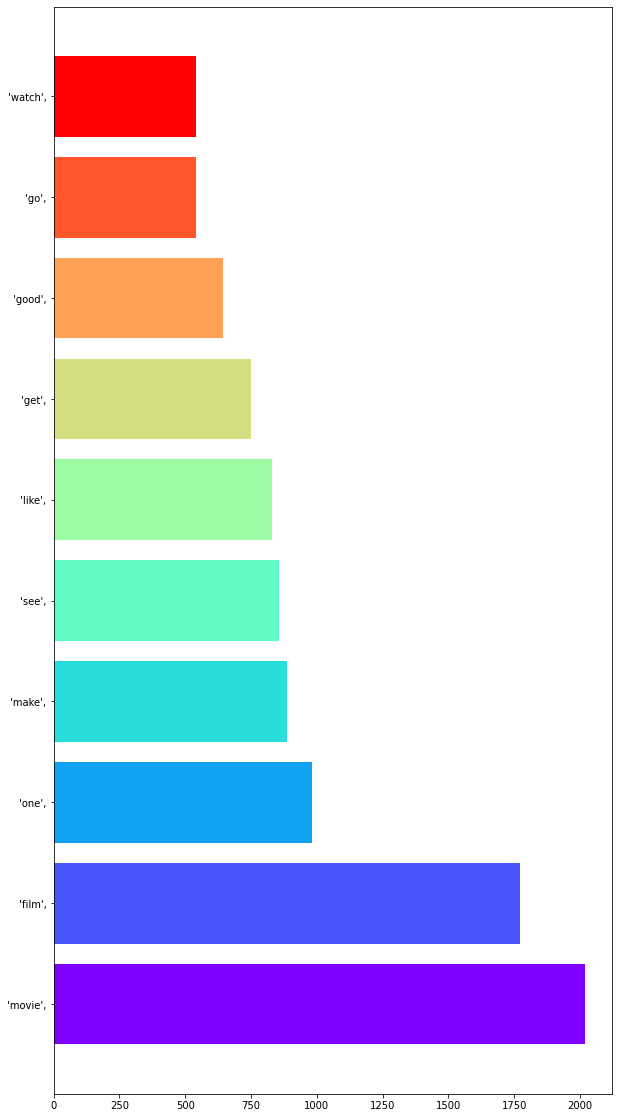

In [67]:
plt.barh(words, counts, color = cm.rainbow(np.linspace(0,1, 10)))

### Sentiment Analysis

In [69]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentence = tokens_without_sw
tokenized_sentence = nltk.word_tokenize(sentence)

sid = SentimentIntensityAnalyzer()
pos_words_list = []
neu_words_list = []
neg_words_list = []

for word in tokenized_sentence:
    if(sid.polarity_scores(word)['compound']) >= 0.1:
        pos_words_list.append(word)
    elif(sid.polarity_scores(word)['compound']) <=0.1:
        neg_words_list.append(word)
    else:
        neu_words_list.append(word)

### Vader Sentiment Analysis for a given sentence

In [70]:
i = 0

for sentence in Text:
    i += 1
    print(sentence)

    ss = sid.polarity_scores(sentence)
    for k in ss:
        print(f'{k}: {ss[k]}')
    if i == 5:
        break

one of the other reviewer have mention that after watch just oz episode youll be hook they be right a this be exactly what happen with me.the first thing that strike me about oz be it utality and unflinching scene of violence which set in right from the word go trust me this be not a show for the faint hearted or timid this show pull no punch with regard to drug sex or violence it be hardcore in the classic use of the word.it be call oz a that be the nickname give to the oswald maximum security state penitentary it focus mainly on emerald city an experimental section of the prison where all the cell have glass front and face inwards so privacy be not high on the agenda em city be home to many .. aryan muslim gangstas latinos christian italian irish and more .... so scuffles death stare dodgy dealing and shady agreement be never far away.i would say the main appeal of the show be due to the fact that it go where other show wouldnt dare forget pretty picture paint for mainstream audience

### Applying the Analyzer for all the sentences in the DataFrame

In [72]:
df['rating'] = Text.apply(sid.polarity_scores)
df = pd.concat([df.drop(['rating'], axis=1), df['rating'].apply(pd.Series)], axis=1)
df

,Text,neg,neu,pos,compound
1,one of the other reviewer have mention that af...,0.187,0.748,0.064,-0.9933
2,a wonderful little production the filming tech...,0.050,0.758,0.192,0.9739
3,i think this be a wonderful way to spend time ...,0.107,0.657,0.236,0.9748
4,basically theres a family where a little boy j...,0.144,0.782,0.074,-0.9080
5,petter matteis love in the time of money be a ...,0.054,0.792,0.154,0.9744
...,...,...,...,...,...
996,nothing be sacred just ask ernie fosselius the...,0.090,0.841,0.068,-0.6117
997,i hat it i hate selfaware pretentious inanity ...,0.210,0.790,0.000,-0.9371
998,i usually try to be professional and construct...,0.193,0.742,0.065,-0.9944
999,if you like me be go to see this in a film his...,0.142,0.721,0.137,-0.7372


### Adding the target (label) to the dataset

In [75]:
i = 0
sentence = df
predicted_values = []

while i<len(sentence):
    if sentence.iloc[i]['compound'] >= 0.5:
        predicted_values.append('positive')
    elif sentence.iloc[i]['compound'] > 0 and sentence.iloc[i]['compound'] < 0.5:
        predicted_values.append('neutral')
    else:
        predicted_values.append('negative')
    i+=1

predicted_values

['negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'negative',
 'neutral',
 'negative',
 'negative',
 'negative',
 'negative',
 'neutral',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'positive',
 'positive',
 'negative',
 'negative',
 'negative',
 'positive',
 'positive',
 'neutral',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'negative',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'negative',
 'neutral',
 'negative',
 'neutral',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'negative',
 'negative',
 'positive',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'negati

Dimensionality Check

In [76]:
len(predicted_values) == len(df)

True

In [ ]:
df['Target'] = predicted_values
df.drop(['neg', 'neu', 'pos'], inplace=True, axis=1)

In [80]:
df

,Text,compound,Target
1,one of the other reviewer have mention that af...,-0.9933,negative
2,a wonderful little production the filming tech...,0.9739,positive
3,i think this be a wonderful way to spend time ...,0.9748,positive
4,basically theres a family where a little boy j...,-0.9080,negative
5,petter matteis love in the time of money be a ...,0.9744,positive
...,...,...,...
996,nothing be sacred just ask ernie fosselius the...,-0.6117,negative
997,i hat it i hate selfaware pretentious inanity ...,-0.9371,negative
998,i usually try to be professional and construct...,-0.9944,negative
999,if you like me be go to see this in a film his...,-0.7372,negative


Imbalance Check

<AxesSubplot:>

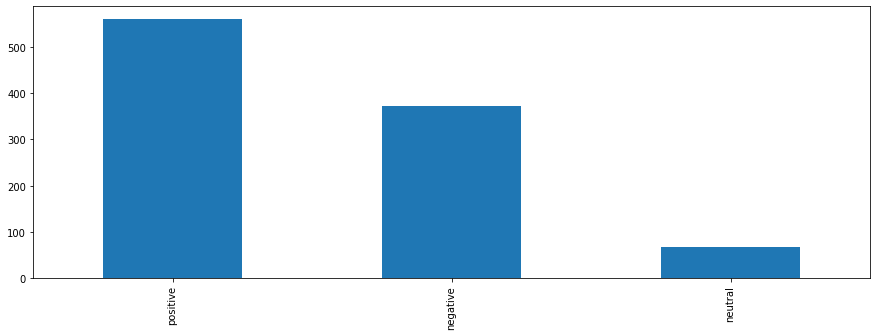

In [82]:
df['Target'].value_counts().plot.bar(figsize=(15,5))

### Encoding the Labels

In [85]:
cat_cols = ['Target']
le = LabelEncoder()
for i in cat_cols:
    df[i] = le.fit_transform(df[i])
df['Target'].value_counts()
df.drop('compound', axis=1, inplace=True)

### Vectorizing the training data

In [86]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['Text'])
y = df['Target']

### Splitting into train and test sets

In [87]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=40)

### Building the Models

In [91]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_auc_score, roc_curve, recall_score

Decision Trees

In [93]:
dt = DecisionTreeClassifier().fit(Xtrain, ytrain)

# Accuracy on train set
print(f'Model train accuracy: {dt.score(Xtrain, ytrain)*100}%')

# Accuracy on test set
print(f'Model train accuracy: {dt.score(Xtest, ytest)*100}%')

# Confusion Matrix
train_pred = dt.predict(Xtrain)
test_pred = dt.predict(Xtest)
print('Confusion Matrix train is:\n', confusion_matrix(ytrain, train_pred))
print('Confusion Matrix test is:\n', confusion_matrix(ytest, test_pred))

Model train accuracy: 100.0%
Model train accuracy: 61.5%
Confusion Matrix train is:
 [[288   0   0]
 [  0  59   0]
 [  0   0 453]]
Confusion Matrix test is:
 [[41  4 39]
 [ 2  1  6]
 [21  5 81]]


Random Forests

In [94]:
rf = RandomForestClassifier().fit(Xtrain, ytrain)

# Accuracy on train set
print(f'Model train accuracy: {rf.score(Xtrain, ytrain)*100}%')

# Accuracy on test set
print(f'Model train accuracy: {rf.score(Xtest, ytest)*100}%')

# Confusion Matrix
train_pred = rf.predict(Xtrain)
test_pred = rf.predict(Xtest)
print('Confusion Matrix train is:\n', confusion_matrix(ytrain, train_pred))
print('Confusion Matrix test is:\n', confusion_matrix(ytest, test_pred))

Model train accuracy: 100.0%
Model train accuracy: 63.5%
Confusion Matrix train is:
 [[288   0   0]
 [  0  59   0]
 [  0   0 453]]
Confusion Matrix test is:
 [[ 22   0  62]
 [  0   0   9]
 [  2   0 105]]


K-Nearest Neighbors

In [95]:
knn = KNeighborsClassifier().fit(Xtrain, ytrain)

# Accuracy on train set
print(f'Model train accuracy: {knn.score(Xtrain, ytrain)*100}%')

# Accuracy on test set
print(f'Model train accuracy: {knn.score(Xtest, ytest)*100}%')

# Confusion Matrix
train_pred = knn.predict(Xtrain)
test_pred = knn.predict(Xtest)
print('Confusion Matrix train is:\n', confusion_matrix(ytrain, train_pred))
print('Confusion Matrix test is:\n', confusion_matrix(ytest, test_pred))

Model train accuracy: 70.875%
Model train accuracy: 56.49999999999999%
Confusion Matrix train is:
 [[124   0 164]
 [ 19   6  34]
 [ 16   0 437]]
Confusion Matrix test is:
 [[15  0 69]
 [ 1  0  8]
 [ 9  0 98]]


Logistic Regression

In [97]:
lr = LogisticRegression().fit(Xtrain, ytrain)

# Accuracy on train set
print(f'Model train accuracy: {lr.score(Xtrain, ytrain)*100}%')

# Accuracy on test set
print(f'Model train accuracy: {lr.score(Xtest, ytest)*100}%')

# Confusion Matrix
train_pred = lr.predict(Xtrain)
test_pred = lr.predict(Xtest)
print('Confusion Matrix train is:\n', confusion_matrix(ytrain, train_pred))
print('Confusion Matrix test is:\n', confusion_matrix(ytest, test_pred))

Model train accuracy: 90.875%
Model train accuracy: 62.0%
Confusion Matrix train is:
 [[274   0  14]
 [  4   0  55]
 [  0   0 453]]
Confusion Matrix test is:
 [[ 22   0  62]
 [  0   0   9]
 [  5   0 102]]


Support Vector Machine

In [98]:
sv = SVC().fit(Xtrain, ytrain)

# Accuracy on train set
print(f'Model train accuracy: {sv.score(Xtrain, ytrain)*100}%')

# Accuracy on test set
print(f'Model train accuracy: {sv.score(Xtest, ytest)*100}%')

# Confusion Matrix
train_pred = sv.predict(Xtrain)
test_pred = sv.predict(Xtest)
print('Confusion Matrix train is:\n', confusion_matrix(ytrain, train_pred))
print('Confusion Matrix test is:\n', confusion_matrix(ytest, test_pred))

Model train accuracy: 94.25%
Model train accuracy: 59.5%
Confusion Matrix train is:
 [[288   0   0]
 [  1  13  45]
 [  0   0 453]]
Confusion Matrix test is:
 [[ 14   0  70]
 [  0   0   9]
 [  2   0 105]]


### Conclusion

In this project, sentiment analysis was carried out on 1000 setences. Preprocessing was carried out on the data by applications of stemming, lemmatization, removal of special characters and stop words, etc. The TFIDFVectorizer was used to vectorize the sentences before the data was exposed to the series of machine learning models used. The scope of this project cuts across any use of language and emotion detection from text. It may be used by a company to better understand the sentiment that their customers share towards a certain product.